In [75]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

from dotenv import load_dotenv
from datetime import datetime, timedelta
from pybit.unified_trading import HTTP
from scipy import stats
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator


%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

load_dotenv()

# Создадим экземпляр класса API биржи и зададим нужные url для работы с другими источниками данных
session = HTTP(testnet=False)
URL_1 = 'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical'
URL_2 = 'https://api.alternative.me/fng/'
API_KEY = os.getenv('API_SECRET')


In [239]:
# Проведем анализ за неполный 2025 год

# Возьмем данные за 2025 год
def extract_data(session=session, date_start='2025-01-01', date_end='2025-12-12', url=URL_1, secret= API_KEY):
    # Функция получает данные цен с биржи и данные индекса
    # Указываем конечную дату на 1 день больше, так как данные по закрытию приходят в 03:00 АМ
    start = int(datetime.strptime(date_start, '%Y-%m-%d').timestamp() * 1000)
    end = int(datetime.strptime(date_end, '%Y-%m-%d').timestamp() * 1000)

    response_exchange = session.get_kline(
        category='inverse',
        symbol='BTCUSDT',
        interval='D',
        start=start,
        end=end,
        limit=367
    )

    headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': secret
    }
    params = {
        'limit': 365
    }
    response_index = requests.get(url, params=params, headers=headers).json()

    return response_exchange['result']['list'], response_index['data']


# Преобразуем данные: загружаем в датафрейм
def transform_data(data1: list, data2: list):
    # Функция обрабатывает полученные данные от биржи.
    # Записывает в DataFrame.
    df = pd.DataFrame(data1, columns=['date', 'open', 'high', 'low', 'close', 'vol', 'turnover'])
    df = df.iloc[:, :6]
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype('float')

    df2 = pd.DataFrame({
        'date': [i['timestamp'] for i in data2],
        'index': [i['value'] for i in data2]
    })
    df2.set_index('date', inplace=True)
    df2.index = pd.to_datetime(df2.index, unit='s')
    df2 = df2.astype('int')

    df3 = pd.concat([df, df2], axis=1, join='inner')
    df3.sort_index(inplace=True)
    rolling = df3['close'].rolling(30, min_periods=1)
    df3['roll_mean'] = rolling.mean()
    df3['roll_median'] = rolling.median()

    return df, df2, df3

def find_periods(df: pd.DataFrame):
    min_index = df.loc[df['index'] < 20].sort_index()
    min_index['date_diff'] = min_index.index.diff().fillna(pd.Timedelta(days=0))

    fragments = []
    current_period = [min_index.iloc[0]]

    for i in range(1, len(min_index)):
        if min_index.iloc[i]['date_diff'] > pd.Timedelta(days=20):
            fragments.append(pd.DataFrame(current_period))
            current_period = [min_index.iloc[i]]
        else:
            current_period.append(min_index.iloc[i])
    fragments.append(pd.DataFrame(current_period))

    return fragments

data_2025, index_2025 = extract_data()
df_2025, df_index, total_2025 = transform_data(data_2025, index_2025)
periods = find_periods(total_2025)
for i, period in enumerate(periods):
    print(f'period {i + 1}:')
    print(period)



period 1:
               open     high      low    close         vol  index  \
2025-03-10  80692.3  84050.0  77403.1  78563.2  201636.174     17   
2025-03-11  78563.2  83622.9  76545.0  82889.2  181108.547     15   
2025-03-12  82889.2  84489.8  80534.6  83649.9  146745.492     19   
2025-03-14  81072.3  85299.9  80766.6  83948.3  102811.840     18   

               roll_mean  roll_median date_diff  
2025-03-10  91665.346667     94939.25    0 days  
2025-03-11  91214.033333     92868.95    1 days  
2025-03-12  90756.223333     91023.00    1 days  
2025-03-14  89804.353333     89282.45    2 days  
period 2:
               open     high      low    close         vol  index  \
2025-04-07  78376.1  81216.8  74456.2  79144.1  292737.153     17   
2025-04-08  79144.1  80833.6  76200.9  76286.9  145001.902     19   
2025-04-09  76286.9  83560.0  74565.9  82593.9  270111.176     15   

               roll_mean  roll_median date_diff  
2025-04-07  83516.373333      83727.9   24 days  
2025-04

C:\Users\deadm\AppData\Local\Temp\ipykernel_18208\2360318941.py:38: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.index = pd.to_datetime(df.index, unit='ms')
C:\Users\deadm\AppData\Local\Temp\ipykernel_18208\2360318941.py:46: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df2.index = pd.to_datetime(df2.index, unit='s')


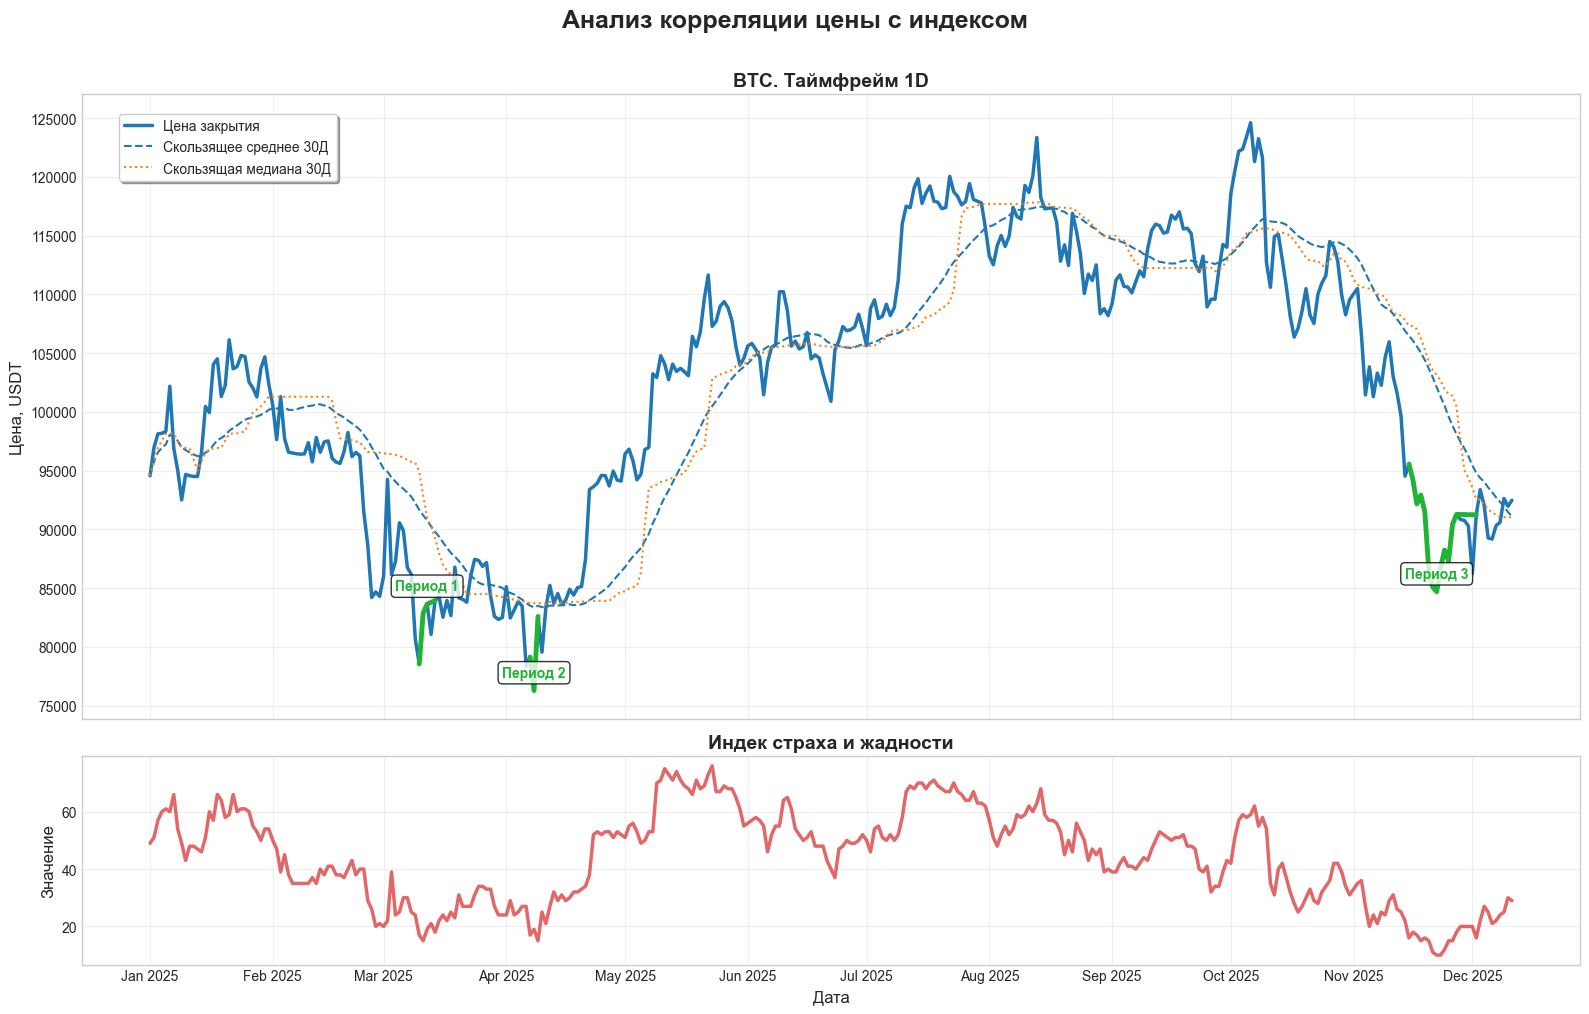

In [240]:
# Визуализируем данные
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Верхний график — цена
ax1.plot(total_2025.index, total_2025.close, color='#1f77b4', linewidth=2.5, label='Цена закрытия')
ax1.plot(total_2025.roll_mean, linestyle='--', linewidth=1.5, label='Скользящее среднее 30Д')
ax1.plot(total_2025.roll_median, linestyle=':', linewidth=1.5, label='Скользящая медиана 30Д')
ax1.set_title('BTC. Таймфрейм 1D', fontsize=14, fontweight='bold')
ax1.set_ylabel('Цена, USDT', fontsize=12)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.yaxis.set_major_locator(MultipleLocator(5000))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
          ncol=1, frameon=True, fancybox=True, shadow=True)

# Наложение периодов низкого индекса
for i, period in enumerate(periods):
    ax1.plot(period.index, period['close'], color="#1fb433", linewidth=3.5, label='Индекс < 20')
    ax1.grid(True, alpha=0.3)

    # Аннотации: подпись над каждым периодом
    mid_date = period.index[len(period) // 2]  # середина периода
    mid_price = period.iloc[len(period) // 2]['close']
    ax1.annotate(f'Период {i+1}',
                xy=(mid_date, mid_price),
                xytext=(0, 10),  # смещение вверх на 10 пунктов
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                color='#1fb433',
                ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))


# Нижний график — индекс
ax2.plot(total_2025['index'], color='#d62728', alpha=0.7, linewidth=2.5, label='Индекс')
ax2.set_title('Индек страха и жадности', fontsize=14, fontweight='bold')
ax2.set_ylabel('Значение', fontsize=12)
ax2.set_xlabel('Дата', fontsize=12)
ax2.grid(True, alpha=0.3)

fig2.suptitle(
    'Анализ корреляции цены с индексом',
    fontsize=18,
    fontweight='bold',
    y = 1.01
)


plt.tight_layout()
plt.show()

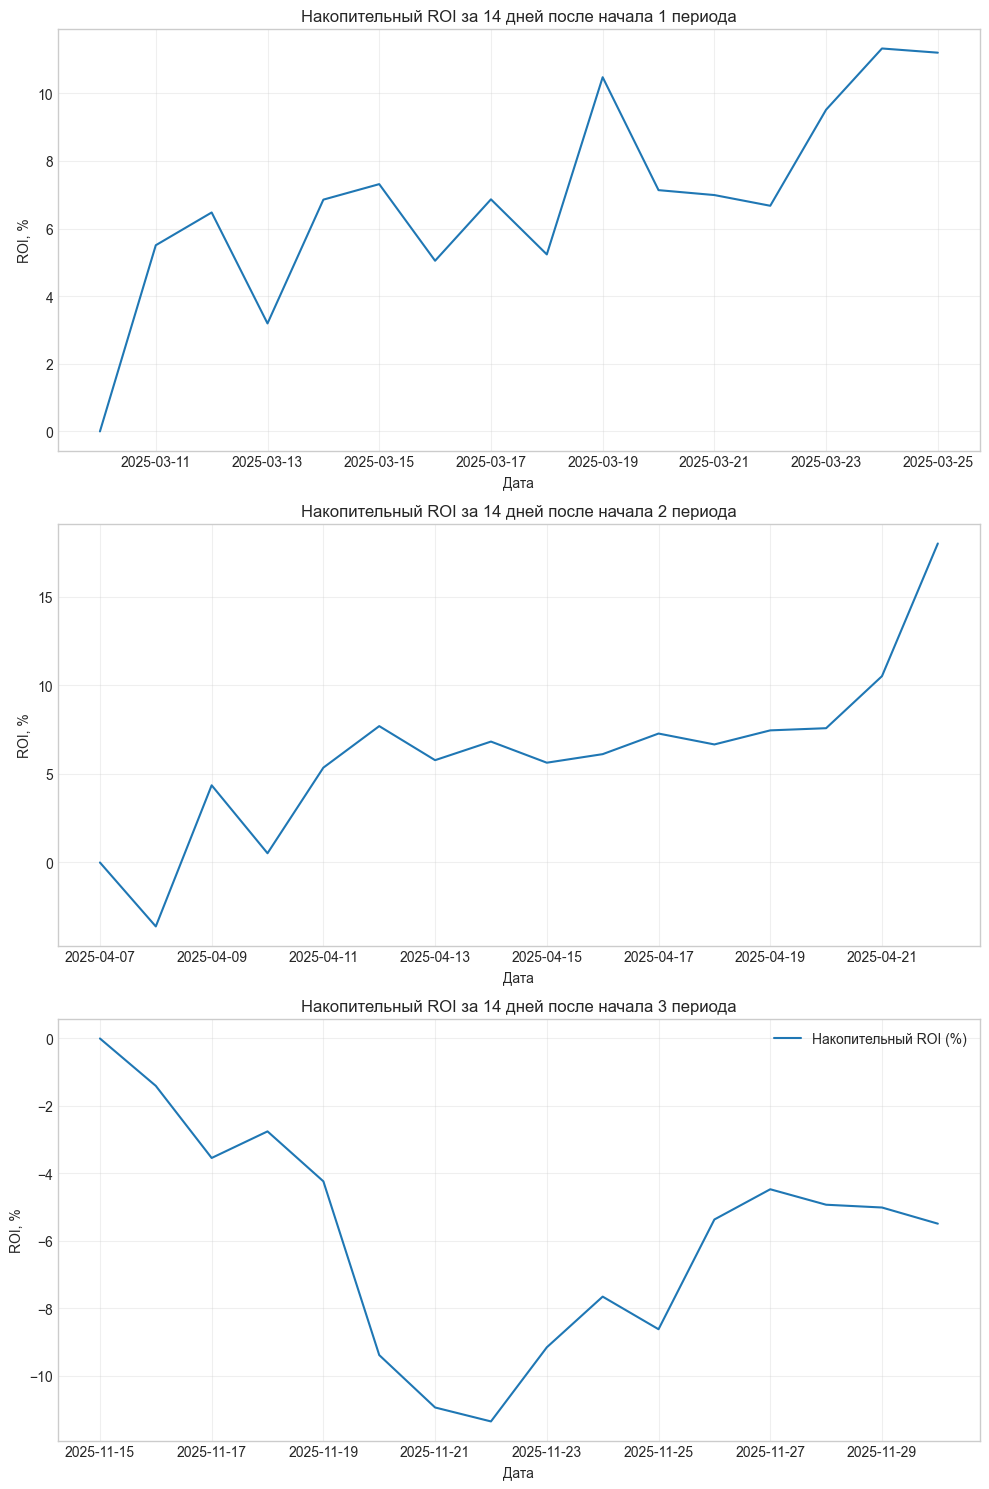

In [269]:
# Посчитаем ROI через два месяца, после начала периода с низким индексом

# Возьмем даты начала каждого периода
def start_dates(data: list):
    # Функция берет на вход список датафреймов кожлго периода,
    # и отсекает только момент начала периода
    # start_low_index = pd.DataFrame()
    # for i, period in enumerate(data):
    #     first_row = period.iloc[[0]]
    #     first_row['period'] = i + 1
    #     start_low_index = pd.concat([start_low_index, first_row])
    start_low_index = pd.concat([
        pd.DataFrame({'period': [i + 1], 'index': period['index'].iloc[[0]]})
        for i, period in enumerate(data)])
    return start_low_index

data_low = start_dates(periods)
# data_low
total_start = pd.concat([total_2025, data_low], axis=1)
total_start = total_start.asfreq('D', method='pad').loc[:, ['close', 'period']]

# Период 1
start_period_1 = total_start.query('period == 1').index.min()
end_period_1 = start_period_1 + pd.Timedelta(days=15)
result = total_start[start_period_1:end_period_1]
result
ROI_1 = 100 * (result.close - result.close.iloc[0]) / result.close.iloc[0]

def roi_periods(data: pd.DataFrame):
    n_periods = [i for i in data_low['period']]
    roi_periods = []
    for i in n_periods:
        start_period = total_start.query(f'period == {i}').index.min()
        end_period = start_period + pd.Timedelta(days=15)
        result = total_start[start_period:end_period]
        ROI = 100 * (result.close - result.close.iloc[0]) / result.close.iloc[0]
        roi_periods.append(ROI)
    
    return roi_periods
    
ROI_all = roi_periods(total_2025)
ROI_all

# Визуализация
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for i, r in enumerate(ROI_all):
    axes[i].plot(r, label='Накопительный ROI (%)')
    axes[i].set_title(f'Накопительный ROI за 14 дней после начала {i + 1} периода')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('ROI, %')
    axes[i].grid(True, alpha=0.3)

plt.legend();
plt.tight_layout()
plt.show()


In [74]:
# Проводим анализ за 2024 год

# Получаем данные: берем данные цены с биржи и данные индекса
def extract_data(session=session, date_start='2024-01-01', date_end='2025-01-02', url=URL_2):
    # Функция получает данные цен с биржи и данные индекса
    # Указываем конечную дату на 1 день больше, так как данные по закрытию приходят в 03:00 АМ
    start = int(datetime.strptime(date_start, '%Y-%m-%d').timestamp() * 1000)
    end = int(datetime.strptime(date_end, '%Y-%m-%d').timestamp() * 1000)

    response_exchange = session.get_kline(
        category='inverse',
        symbol='BTCUSDT',
        interval='D',
        start=start,
        end=end,
        limit=367
    )

    params = {
        'limit': 0
    }
    response_index = requests.get(url, params=params).json()

    return response_exchange['result']['list'], response_index['data']


# Преобразуем данные: загружаем в датафрейм
def transform_data(data1: list, data2: list):
    # Функция обрабатывает полученные данные от биржи.
    # Записывает в DataFrame.
    df = pd.DataFrame(data1, columns=['date', 'open', 'high', 'low', 'close', 'vol', 'turnover'])
    df = df.iloc[:, :6]
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype('float')

    df2 = pd.DataFrame({
        'date': [i['timestamp'] for i in data2],
        'index': [i['value'] for i in data2]
    })
    df2.set_index('date', inplace=True)
    df2.index = pd.to_datetime(df2.index, unit='s')
    df2 = df2.astype('int')

    df3 = pd.concat([df, df2], axis=1, join='inner')
    rolling = df3['close'].rolling(30, min_periods=1)
    df3['roll_mean'] = rolling.mean()
    df3['roll_median'] = rolling.median()

    return df, df2, df3

def find_periods(df: pd.DataFrame):
    min_index = df.loc[df['index'] < 20].sort_index()

    # разбиваем на фрагменты
    min_index['date_diff'] = min_index.index.diff().fillna(pd.Timedelta(days=0))

    fragments = []
    current_period = [min_index.iloc[0]]

    for i in range(1, len(min_index)):
        if min_index.iloc[i]['date_diff'] > pd.Timedelta(days=20):
            fragments.append(pd.DataFrame(current_period))
            current_period = [min_index.iloc[i]]
        else:
            current_period.append(min_index.iloc[i])
    fragments.append(pd.DataFrame(current_period))

    return fragments

data_2024, index_2024 = extract_data()
df_2024, df_index, total_2024 = transform_data(data_2024, index_2024)
periods_2024 = find_periods(total_2024)
# total_2024
for i, period in enumerate(periods_2024):
    print(f'period {i + 1}:')
    print(period)

NameError: name 'URL_2' is not defined

Коэф Спирмена: (p): 0.657
p-value: 0.000000000000000000000000000000000000000000000124


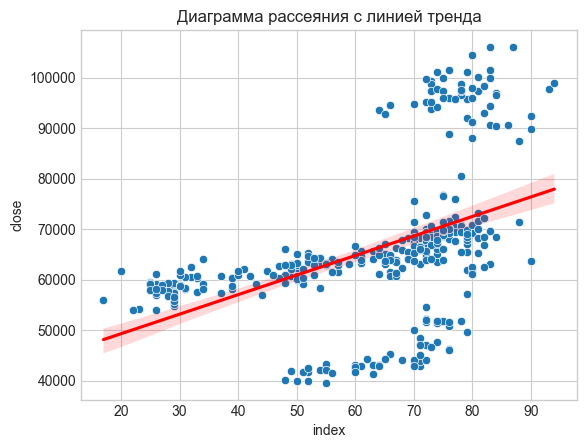

In [5]:
# Посмотрим матрицу корреляции индекса и цены
corr_matrix = total_2024.corr()

rho, p_value = stats.spearmanr(total_2024.close, total_2024['index'])
print(f"Коэф Спирмена: (p): {rho:.3f}")
print(f"p-value: {p_value:.48f}")

# диаграмма рассеяния
sns.scatterplot(data=total_2024, x=total_2024['index'], y=total_2024.close)
sns.regplot(data=total_2024, x=total_2024['index'], y=total_2024.close, scatter=False, color='red')
plt.title('Диаграмма рассеяния с линией тренда')
plt.show()

# построим heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
# plt.tight_layout()
# plt.show()

# Построим scatterplot
# plt.scatter(total_2024.close, total_2024['index'])
# plt.xlabel('price')
# plt.ylabel('index')
# plt.show()

# Q-Q plot
# plt.figure(figsize=(8, 6))
# stats.probplot(total_2024['close'], dist="norm", plot=plt)
# plt.title('Q‑Q plot (проверка на нормальность)')
# plt.show()

# KDE
# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=total_2024['index'], fill=True, color='blue', alpha=0.5)
# plt.title('Плотность распределения цены актива (KDE)')
# plt.xlabel('Цена')
# plt.ylabel('Плотность')
# plt.show()

# KDE + hist
# plt.figure(figsize=(10, 6))
# sns.histplot(data=total_2024['index'], kde=True, bins=10, color='lightblue', edgecolor='black')
# plt.title('Гистограмма и плотность распределения цены')
# plt.xlabel('Цена')
# plt.ylabel('Частота / Плотность')
# plt.show()


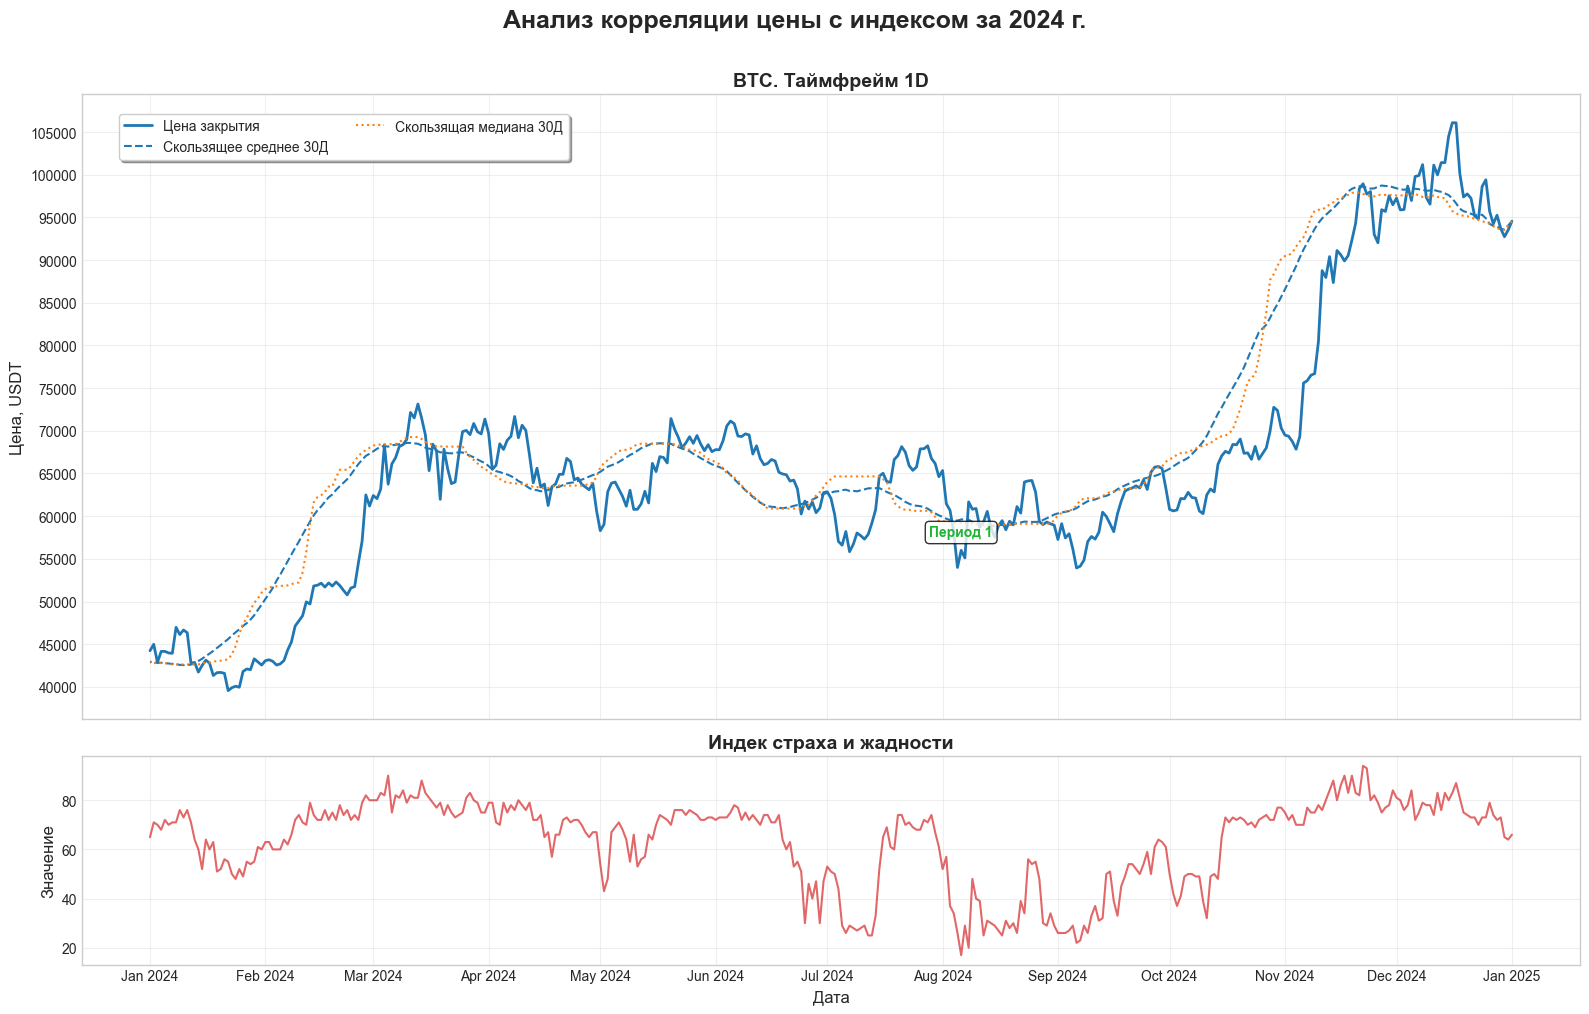

In [ ]:
# Визуализируем данные за 2024 г.

fig3, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Верхний график — цена
ax1.plot(total_2024.index, total_2024.close, color='#1f77b4', linewidth=2, label='Цена закрытия')
ax1.plot(total_2024.roll_mean, linestyle='--', linewidth=1.5, label='Скользящее среднее 30Д')
ax1.plot(total_2024.roll_median, linestyle=':', linewidth=1.5, label='Скользящая медиана 30Д')
ax1.set_title('BTC. Таймфрейм 1D', fontsize=14, fontweight='bold')
ax1.set_ylabel('Цена, USDT', fontsize=12)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.yaxis.set_major_locator(MultipleLocator(5000))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
          ncol=2, frameon=True, fancybox=True, shadow=True)

# Наложение периодов низкого индекса (< 20)
for i, period in enumerate(periods_2024):
    ax1.plot(period.index, period['close'], color="#1fb433", linewidth=3, label='Индекс < 20')
    ax1.grid(True, alpha=0.3)

    # Аннотации: подпись над каждым периодом
    mid_date = period.index[len(period) // 2]  # середина периода
    mid_price = period.iloc[len(period) // 2]['close']
    ax1.annotate(f'Период {i+1}',
                xy=(mid_date, mid_price),
                xytext=(0, 10),  # смещение вверх на 10 пунктов
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                color='#1fb433',
                ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))


# Нижний график — индекс
ax2.plot(total_2024['index'], color='#d62728', alpha=0.7, linewidth=1.5, label='Индекс')
ax2.set_title('Индек страха и жадности', fontsize=14, fontweight='bold')
ax2.set_ylabel('Значение', fontsize=12)
ax2.set_xlabel('Дата', fontsize=12)
ax2.grid(True, alpha=0.3)

fig3.suptitle(
    'Анализ корреляции цены с индексом за 2024 г.',
    fontsize=18,
    fontweight='bold',
    y = 1.01
)


plt.tight_layout()
plt.show()